# Import Cat vs Dog Dataset

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import zipfile

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "cats-and-dogs.zip"

local_zip = 'cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

--2020-12-29 18:47:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.26.50, 2600:1408:2000:6a0::e59, 2600:1408:2000:683::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.62.26.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘cats-and-dogs.zip’

cats-and-dogs.zip   100%[===================>] 786.68M   189MB/s    in 4.2s    

2020-12-29 18:47:55 (187 MB/s) - ‘cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
REBUILD_DATA = True

class DogsVSCats():
  IMG_SIZE = 50
  CATS="PetImages/Cat"
  DOGS="PetImages/Dog"
  LABELS= {CATS: 0, DOGS: 1}
  training_data = []
  catcount = 0
  dogcount = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

          if label == self.CATS:
            self.catcount += 1
          elif label == self.DOGS:
            self.dogcount += 1
        except Exception as e:
          pass

    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)
    print("Cats:", self.catcount)
    print("Dogs:", self.dogcount)

if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()

  1%|          | 89/12501 [00:00<00:14, 882.51it/s]

PetImages/Cat


  1%|          | 99/12501 [00:00<00:12, 977.97it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:14<00:00, 857.50it/s]
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


In [4]:
training_data = np.load("training_data.npy", allow_pickle=True)

print(len(training_data))

24946


[array([[ 75,  28,  27, ...,  89,  95,  90],
       [135, 148, 162, ...,  89, 100, 121],
       [ 45,  46,  60, ...,  91, 111,  82],
       ...,
       [154, 126, 106, ..., 137, 133, 121],
       [214, 223, 204, ..., 131, 126, 116],
       [144, 136, 141, ..., 130, 119, 110]], dtype=uint8)
 array([0., 1.])]


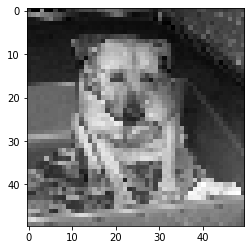

In [5]:
print(training_data[0]) # [1, 0] -> cat; [0, 1] -> dog

plt.imshow(training_data[0][0], cmap="gray")
plt.show()

# Build and Evaluate Model
To calculate number of units used, follow this [tutorial](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb) by Sebastian Raschka.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


In [7]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    """
    InputSize = 50 x 50 (reshaped during making training data). Kernel Size = 5 x 5 (specified below). PoolSize = 2 x 2 (specified below).
    Conv2D layer output size is (InputSize - KernelSize + 1) => (InputSize - 4). This only applies for stride=1 and padding=0
    MaxPool2D layer output size is floor(InputSize/PoolSize) => floor(InputSize/2). This only applies for stride=KernelSize and padding=0
    Calculation: 50x50x1 --conv2d--> 46x46x32 --pool--> 23x23x32 --conv2d--> 19x19x64 --pool--> 9x9x64 --conv2d--> 5x5x128 --pool--> 2x2x128
    """

    self.conv1 = nn.Conv2d(1,32,5)
    self.conv2 = nn.Conv2d(32,64,5)
    self.conv3 = nn.Conv2d(64,128,5)
    self.fc1 = nn.Linear(2*2*128,512)
    self.fc2 = nn.Linear(512,2)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    x = x.view(-1, 2*2*128) # flatten
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [8]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [10]:
BATCH_SIZE = 100
EPOCHS = 3

def train(net):
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time
      #print(f"{i}:{i+BATCH_SIZE}")

      # if the model is on the GPU, the data also needs to be on the GPU
      batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
      batch_y = train_y[i:i+BATCH_SIZE].to(device)

      net.zero_grad()
      optimizer.zero_grad()   # zero the gradient buffers

      outputs = net(batch_X)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step() # Does the update

  print(f"Epoch: {epoch}. Loss: {loss}")

In [11]:
def test(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class = torch.argmax(test_y[i]).to(device)
      net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list
      predicted_class = torch.argmax(net_out)

      if predicted_class == real_class:
        correct += 1
      total += 1

  print("Accuracy: ", round(correct/total, 3))

In [12]:
train(net)

100%|██████████| 225/225 [00:02<00:00, 112.47it/s]

Epoch: 2. Loss: 0.2081940770149231


In [13]:
test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1451.25it/s]

Accuracy:  0.628


In [14]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True) / len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

In [15]:
# sampling the test set at random
def test(size=32):
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start + size], test_y[random_start:random_start + size]

  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))

  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

0.71875 tensor(0.1988, device='cuda:0')


# Model Analysis

In [16]:
import time

MODEL_NAME = f"model-{int(time.time())}" # give the model a dynamic name

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

model-1609267746


In [17]:
BATCH_SIZE = 100
EPOCHS = 30

def train():
  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time

        # if the model is on the GPU, the data also needs to be on the GPU
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)

        if i % 50 == 0: # every 50 steps, track the val loss
          val_acc, val_loss = test(size=100)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train()

100%|██████████| 225/225 [00:05<00:00, 40.95it/s]


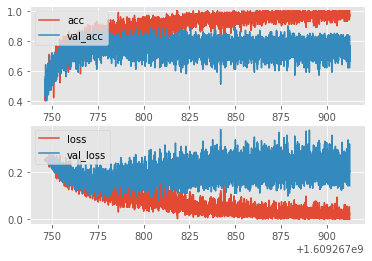

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split("\n")

  times = []
  accuracies = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if MODEL_NAME in c:
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

      times.append(float(timestamp))
      accuracies.append(float(acc))
      losses.append(float(loss))

      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))

  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

  ax1.plot(times, accuracies, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)
  
  ax2.plot(times,losses, label="loss")
  ax2.plot(times,val_losses, label="val_loss")
  ax2.legend(loc=2)
  plt.show()

create_acc_loss_graph(MODEL_NAME)

Conclusion
* Overfitting after 8 epochs: train acc tends to 1.0, train loss tends to 0. This means that the neural networks is memorizing the train data
* Increasing deviation between train and val acc/loss shows that the model cannot generalize.